In [1]:
import time
import h5py
import pickle
import os, sys
import numpy as np
import juliet
from astropy import units
from astropy.io import fits
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import astraeus.xarrayIO as xrio
from scipy.ndimage import median_filter


from scipy.io import wavfile
from scipy.interpolate import interp2d, interp1d
from scipy.interpolate import NearestNDInterpolator

import ccdproc as ccdp
from astropy import units
from astropy.nddata import CCDData
from tqdm import tqdm_notebook
from scipy.interpolate import interp1d
from astropy.table import Table

%load_ext autoreload
%autoreload 2

sys.path.append('/Users/belugawhale/Documents/GitHub/nirhiss')
from src.nirhiss.plotting import stacked_transits
from src.nirhiss.utils import get_MAD_sigma

from matplotlib.colors import ListedColormap
pmap = ListedColormap(np.load('/Users/belugawhale/parula_data.npy'))
colors = np.load('/Users/belugawhale/parula_colors.npy')


COLOR = 'k'
plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.width'] = 3
plt.rcParams['xtick.major.size']  = 10 #12
plt.rcParams['ytick.major.size']  = 10 #12

plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.size']  = 6
plt.rcParams['ytick.minor.size']  = 6

plt.rcParams['axes.linewidth'] = 3

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'

In [2]:
def make_priors_dict(path):
    
    params = ['P_p1', 't0_p1', 'a_p1', 'b_p1', 'q1_SOSS', 'q2_SOSS', 'ecc_p1', 'omega_p1', 
          'p_p1', 'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS', 'GP_sigma_SOSS', 'GP_rho_SOSS']

    dists = ['fixed', 'fixed', 'fixed', 'fixed', 'truncatednormal', 'truncatednormal', 'fixed', 'fixed', 
             'uniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform']

    
    data = np.loadtxt(os.path.join(path, 'priors.dat'), usecols=(2,), dtype='U20')
    hyperps = [np.float64(data[0]), np.float64(data[1]), np.float64(data[2]), np.float64(data[3]), 
               [0., 0.1, 0., 1.], [0., 0.1, 0., 1.], 0.0, np.float64(data[7]), 
               [0., 0.2], 1.0, [0., 0.1], [10., 10000.], [1e-6, 1e2], [1e-5, 1e3]]
    
    prior = juliet.generate_priors(params, dists, hyperps)
    return prior
    
    
def load_juliet(path, time, y, yerr):
    
    priors = make_priors_dict(path)
    
    times = {}
    times['SOSS'] = time

    flux = {}
    flux['SOSS'] = y

    error = {}
    error['SOSS'] = yerr
    
    spct = juliet.load(priors=priors, t_lc=times,
                         y_lc=flux, 
                         yerr_lc=error, 
                         GP_regressors_lc = times,
                         out_folder=path, 
                         ld_laws = 'squareroot')
    results = spct.fit(sampler = 'dynamic_dynesty')
    
    return results


def get_model(results):
    transit_model, transit_up68, transit_low68  = results.lc.evaluate('SOSS', return_err=True)
    return transit_model, transit_up68, transit_low68
    
def get_resid(results, y, yerr, transit_model):
    residuals = (y - transit_model)*1e6
    sigma_SOSS = np.median(results.posteriors['posterior_samples']['sigma_w_SOSS'])*1e-6
    resid_errors = np.sqrt(yerr**2 + sigma_SOSS**2)*1e6
    return residuals, resid_errors
    

def plot_model(transit_model, transit_up68, transit_low68, ax, t0time, offset):
    ax.plot(t0time, transit_model-offset, 'k')
    ax.fill_between(t0time, transit_low68-offset, transit_up68-offset, alpha=0.5, color='k', lw=0)
    return

def plot_residuals(t0time, residuals, resid_errors, color, ax, offset):
    ax.errorbar(t0time, residuals-offset, yerr=resid_errors-offset, marker='.',
                color=color, linestyle='')
    return residuals, resid_errors

def load_data(path):
    dat = np.loadtxt(os.path.join(path, 'lc.dat'), usecols=(0,1,2))
    return dat[:,0], dat[:,1], dat[:,2]

In [3]:
def replace_outliers(array, idx_outliers, residuals):
    for idx in idx_outliers:
        
        if idx == 0:
            replacement = 1
        elif idx == len(residuals)-1:
            replacement = len(residuals)-2
        else:
            replacement = idx + 1

            if replacement in idx_outliers:
                replacement = idx + 2

        try:
            array[idx] = array[replacement]
        except:
            pass
    return array


def rmv_outliers(flux, filtersize=25, sigmacutoff=5, plot='residuals', idx_outliers=None):
    residuals = flux - median_filter(flux, filtersize)
    sigma = get_MAD_sigma(np.nanmedian(residuals), residuals)
    
    if idx_outliers is None:
        idx_outliers = np.where(np.abs(residuals) > sigmacutoff*sigma)[0]
    
    if plot=='residuals':
        plt.plot(np.arange(0,len(flux),1), residuals)
        plt.plot(np.arange(0,len(flux),1)[idx_outliers], residuals[idx_outliers], '.')
        plt.title(np.round(sigmacutoff*sigma, 2))
    elif plot=='lc':
        plt.plot(np.arange(0,len(flux),1), flux, '.')
        plt.plot(np.arange(0,len(flux),1)[idx_outliers], flux[idx_outliers], '.')
        plt.show()
    else:
        pass

    if len(idx_outliers) > 0:

        print('Found', len(idx_outliers), 'outliers')

        flux = replace_outliers(flux, idx_outliers, residuals)

    return flux, idx_outliers

In [5]:
data1 = np.load('/Users/belugawhale/Downloads/NIRISS_WASP-39_ADF_order1_all_models_and_LCs.npy',
               allow_pickle=True).item()
data2 = np.load('/Users/belugawhale/Downloads/NIRISS_WASP-39_ADF_order2_all_models_and_LCs.npy',
               allow_pickle=True).item()

In [6]:
err1 = np.load('/Users/belugawhale/Downloads/ADF_wasp-39_order1_stellar_spectra_v10.npy',
               allow_pickle=True)
err2 = np.load('/Users/belugawhale/Downloads/ADF_wasp-39_order2_stellar_spectra_v10.npy',
               allow_pickle=True)

In [7]:
idx_oot = np.append(np.arange(0,200,1,dtype=int),
                    np.arange(400,len(data1['time']),1,dtype=int))
idx_in = np.arange(200,400,1,dtype=int)


In [8]:
list(data2.keys())[-5:]

['w2039',
 'lc_w2039',
 'transit_model_w2039',
 'polynomial_model_w2039',
 'combined_model_w2039']

In [9]:
def avg_lightcurves(index, data, err, per=5):
    global idx_oot
    
    flux  = np.zeros((per*2+1, len(data['time'])))
    model = np.zeros((per*2+1, len(data['time'])))
    error = np.zeros((per*2+1, len(data['time'])))
    fnorm = np.zeros((per*2+1, len(data['time'])))
    wrange = np.zeros(per*2+1)
    
    for j in range(i-per, i+per+1):
        flux[j-(i-per)]  = data['lc_w{}'.format(j)]
        model[j-(i-per)] = data['combined_model_w{}'.format(i)]
        
        eind = np.where(err[1] <=
                        data['w{}'.format(j)][0].value)[0][0]
        
        error[j-(i-per)] = err[3][:,eind]
        fnorm[j-(i-per)] = err[2][:,eind]
        wrange[j-(i-per)] = data['w{}'.format(j)][0].value
        
    wrange = np.sort(wrange)
    wmed = wrange[5]
    low,upp = wrange[5]-wrange[0], wrange[-1]-wrange[5]
    lim = np.round(np.nanmedian([low,upp]),3)

    e = (np.sqrt(np.nansum(error,axis=0))/len(error))/np.nanmax(fnorm)
    f = np.nanmean(flux, axis=0)
    m = np.nanmax(model[-2:], axis=0)
    
    f /= np.nanmedian(f[idx_oot])
    m /= np.nanmedian(m[idx_oot])
    
    return f, e, m, wmed, lim, wrange[0], wrange[-1], model, flux

In [10]:
start = 20
n = 8
per = 9

In [11]:
np.linspace(368,880,n,dtype=int)

array([368, 441, 514, 587, 660, 733, 806, 880])

In [12]:
np.linspace(368,880,n,dtype=int)

array([368, 441, 514, 587, 660, 733, 806, 880])

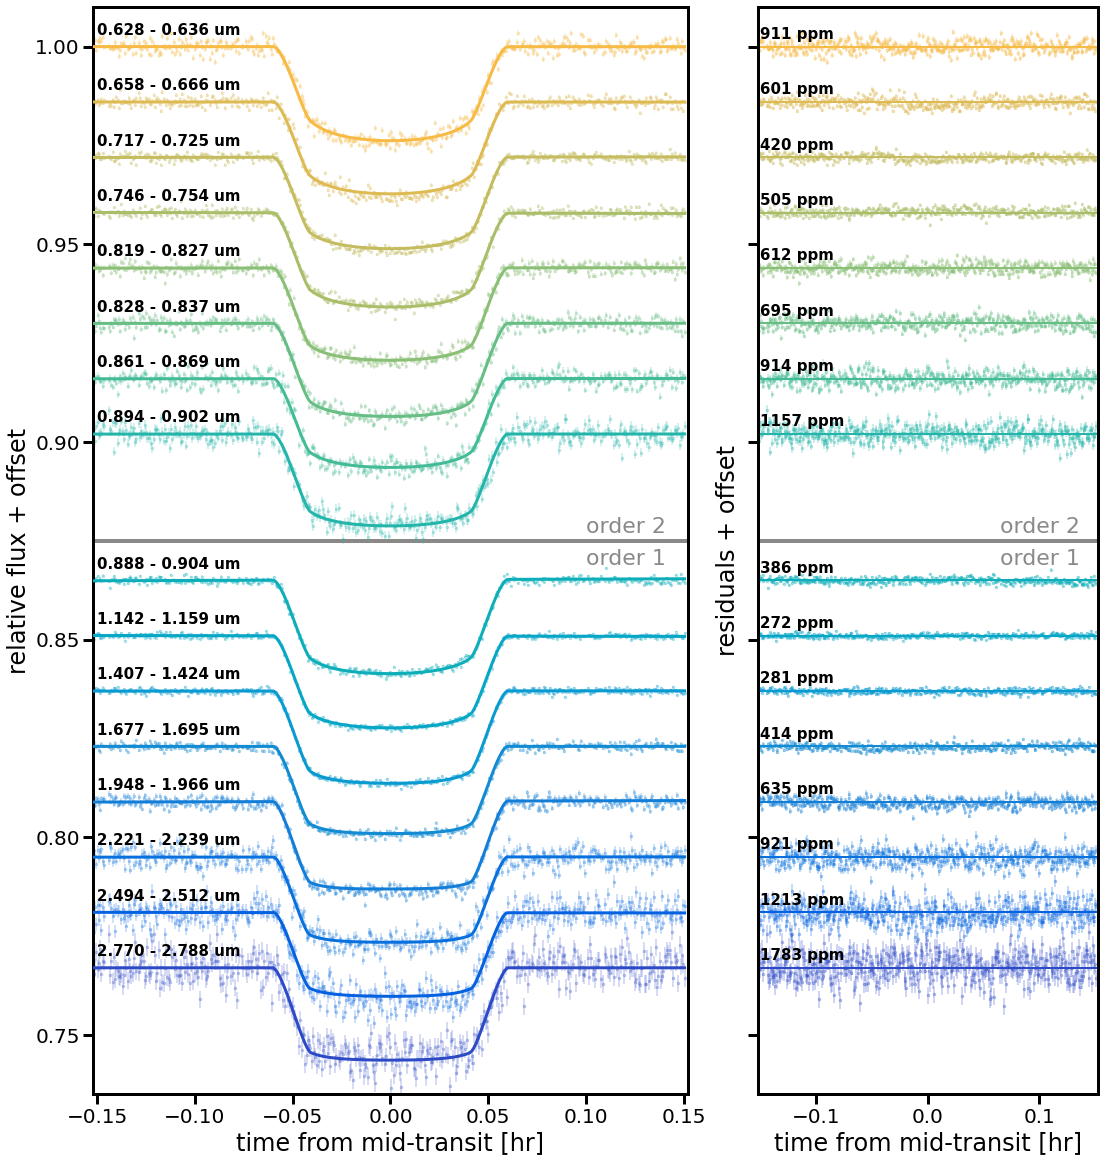

In [19]:
fig, (ax1,ax2) = plt.subplots(ncols=2, gridspec_kw={'width_ratios':[1.75,1]},
                              figsize=(18,20))
fig.set_facecolor('w')

n = 8
temp_colors = colors[np.append(np.flip(np.linspace(20,210,n*2,dtype=int)[n:]),
                               np.flip(np.linspace(20,210,n*2,dtype=int)[:n])
                               )]
midpoint = (0.556726+2459787) - 2400000
offset = 0.014
c, o = 0, 0
textx = -0.15
alpha=0.25

text_kwargs = {'color':'k', 'zorder':20, 'fontsize':15,
               'fontweight':'bold'}

# ORDER 2 LIGHT CURVES
n = 8
inds = [368, 440, 575, 640, 800, 820, 890, 960]#np.linspace(368,880,n,dtype=int)
for i in inds:
    flux, err, model, wmed, wlim, wlow, wupp,_,_ = avg_lightcurves(i, data2, 
                                                                   err2, per=per)
    
    rms = get_MAD_sigma(np.median(np.abs(flux-model)[idx_oot] - 1.), 
                                  np.abs(flux-model)[idx_oot] - 1.)*1e6
    
    ax1.errorbar(data2['time']-midpoint, flux-offset*o,
                 yerr=err, linestyle='', marker='.',
                 color=temp_colors[c], alpha=alpha)
    
    ax1.plot(data2['time']-midpoint, model-offset*o, 
             zorder=10,
             color=temp_colors[c], lw=3)
    

    ax1.text(s=r'{:.3f} - {:.3f} um'.format(np.round(wlow,3), 
                                            np.round(wupp,3)),
             x=textx, y=1.003-(offset*o), **text_kwargs)
    
    ax2.text(s=r'{} ppm'.format(int(np.round(rms,0))),
             x=textx, y=0.002-(offset*o), **text_kwargs)
    
    ax2.errorbar(data2['time']-midpoint, (flux-model)-offset*o,
                 yerr=err,
                 linestyle='', marker='.',
                 color=temp_colors[c], alpha=0.3)
    
    ax2.axhline(-offset*o, color=temp_colors[c], zorder=0, lw=2)
    
    o += 1
    c += 1

hline_dict = {'color':'#8a8988', 'lw':4, 'zorder':0}
ax1.axhline(1-(offset*o+0.013), **hline_dict)
ax2.axhline(0-(offset*o+0.013), **hline_dict)

ax1.text(s='order 2', x=0.10, y=1-(offset*o+0.011), color=hline_dict['color'],
         fontsize=22)
ax1.text(s='order 1', x=0.10, y=1-(offset*o+0.019), color=hline_dict['color'],
         fontsize=22)

ax2.text(s='order 2', x=0.065, y=0-(offset*o+0.011), color=hline_dict['color'],
         fontsize=22)
ax2.text(s='order 1', x=0.065, y=0-(offset*o+0.019), color=hline_dict['color'],
         fontsize=22)

add_offset = 0.023
n = 8
inds = np.linspace(25,2012-25*2,n,dtype=int)

# ORDER 1 LIGHT CURVES
for i in inds:
    flux, err, model, wmed, wlim, wlow, wupp,_,_ = avg_lightcurves(i, data1, 
                                                                   err1, per=per)
    rms = get_MAD_sigma(np.median(np.abs(flux-model)[idx_oot] - 1.), 
                                  np.abs(flux-model)[idx_oot] - 1.)*1e6

    ax1.errorbar(data1['time']-midpoint, flux-offset*o-add_offset,
                 yerr=err, linestyle='', marker='.',
                 color=temp_colors[c], alpha=alpha)
    
    ax1.plot(data1['time']-midpoint, model-offset*o-add_offset, 
             zorder=10,
             color=temp_colors[c], lw=3)
    
    ax1.text(s=r'{:.3f} - {:.3f} um'.format(np.round(wlow,3), 
                                      np.round(wupp,3)),
             x=textx, y=1.003-(offset*o)-add_offset, **text_kwargs)
    
    ax2.text(s=r'{} ppm'.format(int(np.round(rms,0))),
             x=textx, y=0.002-(offset*o)-add_offset, **text_kwargs)
    
    ax2.errorbar(data1['time']-midpoint, (flux-model)-offset*o-add_offset,
                 yerr=err,
                 linestyle='', marker='.',
                 color=temp_colors[c], alpha=0.3)
    
    ax2.axhline(-offset*o-add_offset, color=temp_colors[c], zorder=0, lw=2)
    
    o += 1
    c += 1


ax1.set_xlim(-0.152,0.152)
ax2.set_xlim(-0.152,0.152)

fs = 24
ax2.set_ylabel('residuals + offset'.format(i+1), fontsize=fs)
ax1.set_ylabel('relative flux + offset'.format(i+1), fontsize=fs)
ax1.set_xlabel('time from mid-transit [hr]', fontsize=fs)
ax2.set_xlabel('time from mid-transit [hr]', fontsize=fs)
    
ax1.set_ylim(0.735, 1.01)
ax2.set_ylim(-0.265, 0.01)
ax2.set_yticklabels([])

ax1.set_rasterized(True)
ax2.set_rasterized(True)
    
plt.subplots_adjust(wspace=0.15, hspace=0)
plt.savefig('/Users/belugawhale/Documents/niriss_real/wasp39/paper_figures/spec_lcs.pdf', 
            dpi=200, rasterize=True,
            bbox_inches='tight')

In [131]:
np.linspace(data2['w370'][0], data2['w1000'][0], 8)

<Quantity [0.63263357, 0.6732412 , 0.71384883, 0.75445646, 0.79506408,
           0.83567171, 0.87627934, 0.91688697] micron>

In [132]:
np.linspace(370,1000,n,dtype=int)

array([ 370,  460,  550,  640,  730,  820,  910, 1000])

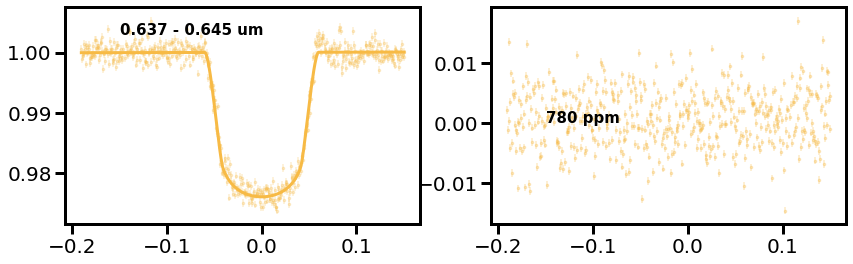

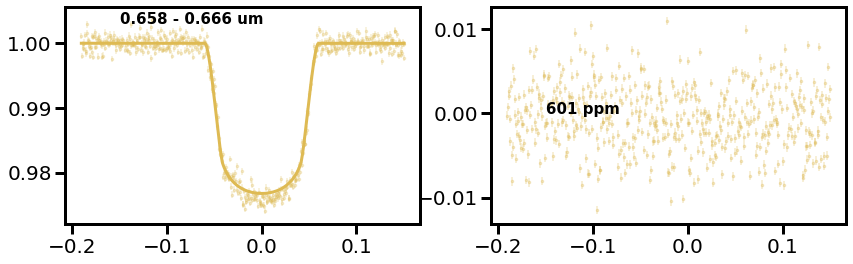

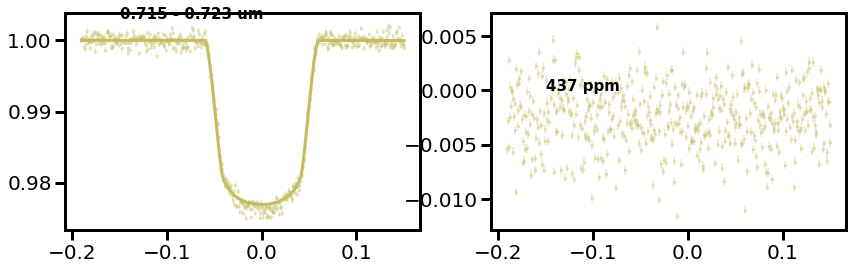

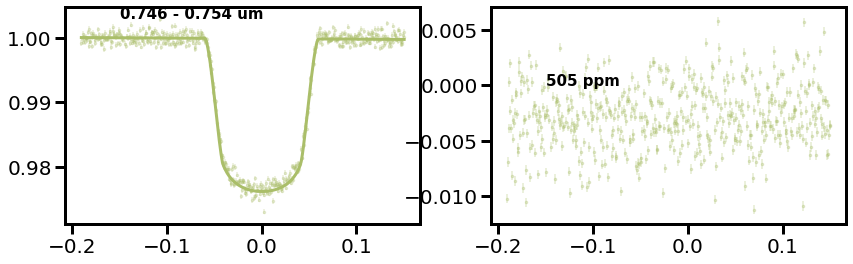

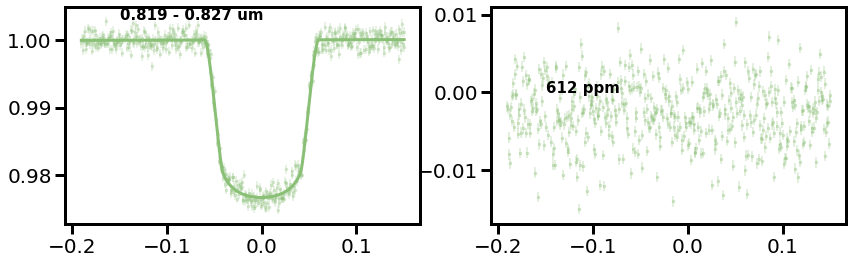

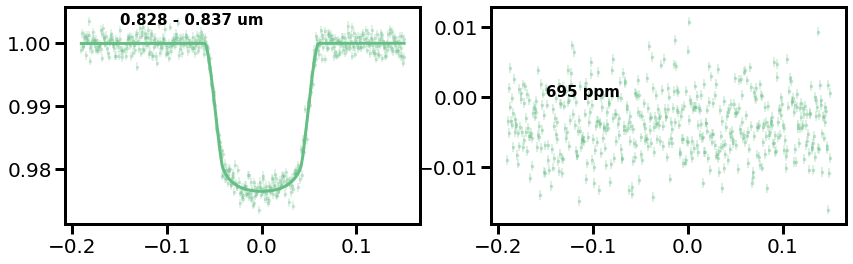

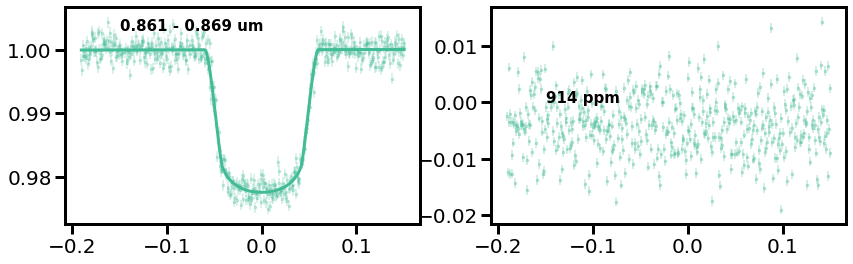

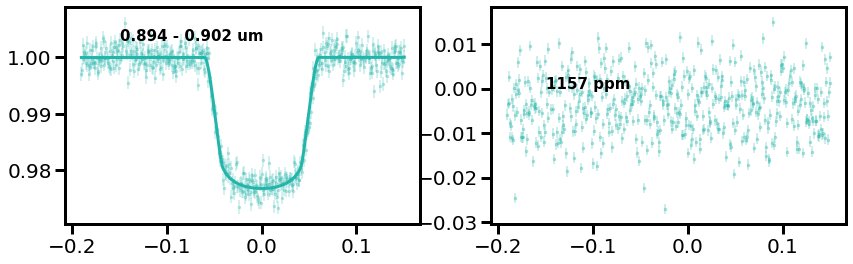

In [133]:
n = 8
c=0
per=9
inds = np.linspace(370,1000,n,dtype=int)
inds = [390, 440, 570, 640, 800, 820, 890, 960]
for i in inds:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    flux, err, model, wmed, wlim, wlow, wupp, all_models, all_fluxes = avg_lightcurves(i, data2, 
                                                                           err2, per=per)
    
    rms = get_MAD_sigma(np.median(np.abs(flux-model)[idx_oot] - 1.), 
                                  np.abs(flux-model)[idx_oot] - 1.)*1e6
    
    ax1.errorbar(data2['time']-midpoint, flux,
                 yerr=err, linestyle='', marker='.',
                 color=temp_colors[c], alpha=alpha)
    ax1.plot(data2['time']-midpoint, model,
             zorder=10,
             color=temp_colors[c], lw=3)


    ax1.text(s=r'{:.3f} - {:.3f} um'.format(np.round(wlow,3), 
                                            np.round(wupp,3)),
             x=textx, y=1.003, **text_kwargs)
    
    ax2.errorbar(data1['time']-midpoint, (all_fluxes[0]-all_models[0]),
                 yerr=err,
                 linestyle='', marker='.',
                 color=temp_colors[c], alpha=0.3)
    
    rms = get_MAD_sigma(np.median(np.abs(flux-model)[idx_oot] - 1.), 
                                  np.abs(flux-model)[idx_oot] - 1.)*1e6

   
    ax2.text(s=r'{} ppm'.format(int(np.round(rms,0))),
             x=textx, y=0.00, **text_kwargs)
    
    plt.show()
    c += 1

In [134]:
ts = Table.read('/Users/belugawhale/Documents/GitHub/wasp39b_paper/data/ts/CMADF-WASP_39b_NIRISS_transmission_spectrum_highres.csv',
                format='csv', comment='#')

In [135]:
np.nanstd(data1['lc_w0'][idx_oot])

0.002628889974918759

In [174]:
np.nanmedian((ts[ts['order']==2]['dppm']/1e6)*np.sqrt(len(idx_in))/np.nanstd(data2['lc_w500'][idx_oot]))

103.0955670004917

In [161]:
np.nanmedian((ts[ts['order']==1]['dppm']/1e6)*np.sqrt(len(idx_in))/np.nanstd(data1['lc_w1021'][idx_oot]))

91.1051542748387

In [173]:
data2['w550']

[<Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quantity 0.71010039 micron>,
 <Quanti